# Emotion Detector

We will build emotion detector from a dataset that represents English Twitter messages.

CARER : Contextualized Affect Representations for Emotion Recognition (https://aclanthology.org/D18-1404/)

### Importing Dependecies

In [1]:
from install import *

In [2]:
install_requirements(is_classification = True)

⏳ Installing base requirements ...
✅ Base requirements installed!


In [3]:
from utils import *

In [4]:
setup_task()

Using transformers v4.13.0
Using datasets v1.16.1


### Exploring Hugging Face Datasets

In [5]:
from datasets import list_datasets

In [6]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")

There are 14098 datasets currently available on the Hub


In [7]:
from datasets import load_dataset

In [8]:
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [11]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6,
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None,
id=None)}


In [12]:
train_ds[0:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3]}

In [13]:
import pandas as pd

In [14]:
emotions.set_format(type = 'pandas')
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [16]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Exploratory Data Analysis (EDA)

1. Class Distribution
2. How long are the tweets

In [17]:
import matplotlib.pyplot as plt


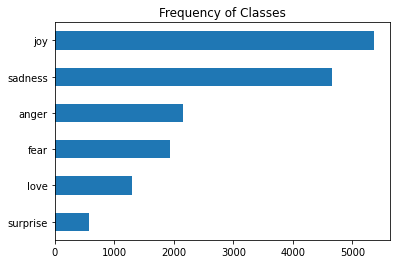

In [18]:
df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Here, the dataset is heavily imbalanced. We can see that "joy" and "sadness" appear the most and least are "love" and "surprise".

The way we could handle this is by - 

* Randomly oversample the minority class
* Randomly undersample the majority class
* Gather more labeled data from the underrepresented classes.

We will later explore on the Imbalancedlearn library (https://imbalanced-learn.org/stable/).

Make sure you apply sampling methods after creating your train / test splits or there will be plenty of leakage between them.

In [19]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


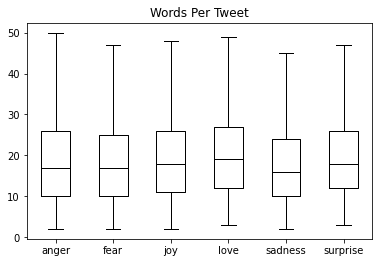

In [20]:
df.boxplot("Words Per Tweet", by = "label_name", grid = False, showfliers = False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Here, on an average tweets have close to 20 words. Very long ones are close to 50. So, there will be no issue to set these into the maximum context size of the transformer models like BERT etc.

In [21]:
# Let's reset the output format from Dataframe to DatasetDict and carry out varipus operations
emotions.reset_format()

In [22]:
type(emotions)

datasets.dataset_dict.DatasetDict

### From Text To Tokens

For any ML models we need to tokenize and encode the strings to numerical vectors. Tokenization is a process of breaking down a string into the atomic units used in the model. Let's look at two types of tokenization.

1. Character tokenization
2. Word tokenization
3. Subword tokenization

In the end we will use the tokenizer from the transformer model.

Character Tokenization : Feed each character individually to the model

In [23]:
text = "Tokenizing text is a core task of NLP."
print(list(text))

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [24]:
def characterTokenization(text):
  tokenized_text = list(text)
  token2idx = {}
  for idx, ch in enumerate(sorted(set(tokenized_text))):
    token2idx[ch] = idx
  return token2idx, tokenized_text

In [25]:
token2idx, tokenized_text = characterTokenization(text)
print(token2idx)
print("")
print(tokenized_text)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [26]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token has now been mapped to a unique numerical identifier, hence we call this as input_ids. Now we need to convert these input_ids to a 2D tensor of one-hot vectors.

In [27]:
import torch
import torch.nn.functional as F

In [28]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions, since our vocabulary consists of 20 unique characters.

We can see here that character-level tokenization ignores any structrure in the text and treats the whole string as a stream of characters.

The positive here is it deals with misspellings and rare words but the main drawback is that liguistic structure such as words need to be learnt from the data. This is not practical as would need more data, compute and memory.

Hence, character level tokenization is seldom used.

Word Tokenization : 

Split the text into words and map each word to an integer. But the problem here would be the number of words as the vocab size which is directly proportional to the number of parameters.

So, a nice compromise would be between character and word tokenization. This is also called as Subword Tokenization

Subword Tokenization

In [29]:
from transformers import AutoTokenizer
# The AutoTokenizer class automatically retrieve the model's configuration, pre-trained weights or vocabulary from
# the name of the checkpoint.

In [30]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [31]:
text

'Tokenizing text is a core task of NLP.'

In [32]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


Some observations-

1. Special tokens like [CLS] (start of the sequence) and [SEP] (end of the sequence)
2. Tokens have been lowercased (feature of this particular) checkpoint
3. The uncommon words like "tokenizing" and "nlp" have been split into two tokens as they are not common words. A prefix of "##" means the preceeding string is not a whitespace, hence they are part of the previous token so they need to be merged while reconstructing them

In [34]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [35]:
tokenizer.vocab_size

30522

In [36]:
tokenizer.model_max_length

512

In [37]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Tokenizing the Whole Dataset

In [38]:
def tokenize(batch):
  '''
    padding = True will pad the examples with zeros to the size of the longest one in a batch.
    truncation = True will truncate the examples to the model's maximum context size.
  '''
  return tokenizer(batch["text"], padding = True, truncation = True)

In [39]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


Special Token : [PAD], [UNK], [CLS], [SEP], [MASK]

Special Token ID : 0, 100, 101, 102, 103

The attention mask allows the model to ignore the padded parts of the input

In [40]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [41]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

# Here, map() operates individually on every example in the corpus, so setting batched = True will
# encode the tweets in batched. Setting batch_size = None, will make tokenize applied to the full
# dataset as a single batch which will ensure that the input tensors and attention masks have the 
# same shape globally

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [42]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

### Training a Text Classifier

1. The text is tokenized and represented as one-hot vectors called token encodings
2. The size of the tokenizer vocabulary determines the dimension of the token encodings, which is usually consists of 20K - 200K unique tokens.
3. Token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space.
4. These token embeddings are then passed through the encoder block layers to yield a hidden state for **each input token**.
5. For the pre-training objective of language modeling (for DistillBERT, it was to predict the masked tokens), each hidden state is fed to a layer that predicts the masked input tokens. On a similar note for the classification task which we are performing right now on the Emotions dataset, we will replace the language modeling layer with a classification layer.


**Note** : In practice PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix.


We have two options to train such a model in our Twitter dataset -

1. Feature Extraction : We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

2. Fine-Tuning : We train the whole model end-to-end, which also updates the parameters of the pre-trained model

a. Transformers as Feature Extractors -

Here, we freeze the body's weights during the training and use the hidden states as features for the classifier. This is also called as a Shallow Model as hidden states only need to be computer once and there will be no need of a backpropagation across the entire network to update the parameters.

In [43]:
from transformers import AutoModel

In [44]:
model_ckpt

'distilbert-base-uncased'

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. 

Let's see how we extract the hidden states for a single string and then we do it for the entire corpus.

In [47]:
text = "this is a test to check the token embeddings using AutoModel class"
inputs = tokenizer(text, return_tensors = "pt") # convert the tokens to PyTorch tensors
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 19])


The resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final setp is to place them on the same device as the model and pass the inputs to get the token embeddings as the hidden states

In [48]:
inputs

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  2000,  4638,  1996, 19204,  7861,
          8270,  4667,  2015,  2478,  8285,  5302,  9247,  2465,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [49]:
inputs = {k:v.to(device) for k, v in inputs.items()}
inputs

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  2000,  4638,  1996, 19204,  7861,
           8270,  4667,  2015,  2478,  8285,  5302,  9247,  2465,   102]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [50]:
# the forward pass (no back propagation)

with torch.no_grad():
  outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.3533, -0.3394, -0.2115,  ...,
-0.2276, -0.1487,  0.7120],
         [-0.4743, -0.5660, -0.4476,  ...,  0.0398,  0.0131,  0.4260],
         [-0.5780, -0.3490, -0.0858,  ...,  0.0416, -0.3763,  0.7896],
         ...,
         [ 0.4398, -0.0047, -0.0427,  ..., -0.3481, -0.6788, -0.0264],
         [ 0.2169, -0.3992, -0.2494,  ..., -0.3446, -0.4947,  0.2618],
         [ 0.9319, -0.0729, -0.5763,  ...,  0.1497, -0.8546, -0.1007]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [51]:
outputs.last_hidden_state.size()

torch.Size([1, 19, 768])

Here, the shape of the hidden state tensor is [batch_size, n_tokens, hidden_dim]
In other words, a 768-dimensional vector is returned for each of the 19 input tokens.

For classification task it is common practice to just use the hidden state associated with the [CLS] token as the input feature. As [CLS] is the first token so we can return it just querying the first index

In [52]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

Let's get the hidden state for the entire dataset

In [53]:
def extract_hidden_states(batch):
  # place the model inputs to the GPU
  inputs = {k:v.to(device) for k, v in batch.items()
                  if k in tokenizer.model_input_names}
  
  # Extract last hidden states -
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return the vector for the [CLS] token
  return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

Here, in the end we place the final hidden state back on the CPU as a NumPy array. The map() method requires the processing function to return Python or NumPy objects when we are using batched inputs

Let's convert the input_ids and attention_mask columns to the "torch" format as our model expects tensors as inputs

In [54]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

In [55]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [56]:
# Let's extract the hidden states across all splits in one go , here default batch_size = 1000 is used -

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [57]:
emotions_hidden
# Note : 'hidden_state' ([CLS] token embeddings) is now associated for each tweet 

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

Now we can train a classifier on them. Let's convert these hidden states into a feature matrix

Creating a Feature Matrix

In [58]:
import numpy as np

In [59]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

In [60]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualizing the training set

Using UMAP algorithm we will project the 768 dimensional vectors to 2D. UMAP works best when the features are scaled to lie in the [0, 1] interval.

UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction [UMAP](https://arxiv.org/abs/1802.03426)

In [61]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [62]:
# Scale the features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components = 2, metric = "cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns = ["X", "Y"])
df_emb["label"] = y_train

In [63]:
df_emb.head()

,X,Y,label
0,4.455972,6.974013,0
1,-2.814642,6.015271,0
2,5.689976,3.438767,3
3,-1.993959,3.962781,2
4,-2.959278,4.002751,3


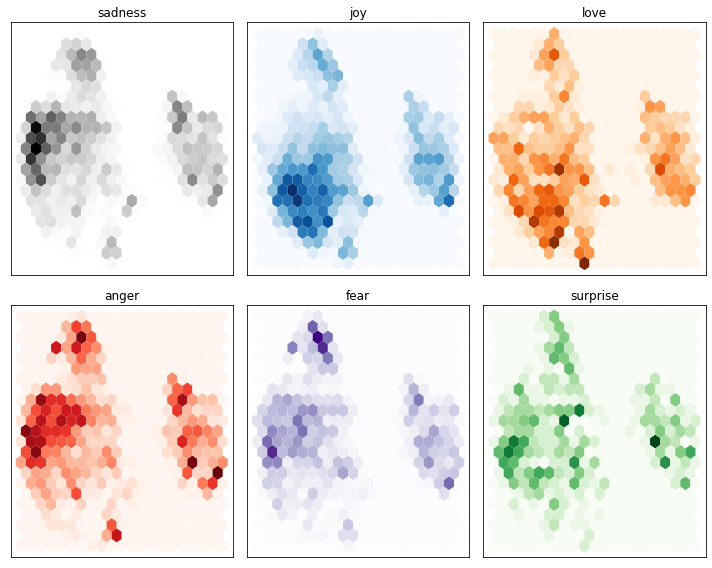

In [64]:
fig, axes = plt.subplots(2, 3, figsize = (10, 8))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap = cmap, gridsize = 20, linewidths = (0, ))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From the above visualization we can see some patterns -

1. The negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions.

2. Joy and Love are well separated from negative emotions and also share a similar space.

3. Surprise is scattered all over the place.

**Note** : The separation is not guaranteed since the model was not trained to know the different between these emotions. It only learned them implicitly by guessing the masked words in texts

Training a shallow classfier 

We will train a logistic regression model.

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
# Let's increase the max_iter to guarantee convergence

lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

To keep in mind we are dealing with an unbalanced multiclass dataset. Let's build a baseline and see how the model is behaving. 

Let's choose a simple heuristics such as always choosing the majority class or drawing from a random class. Here, the best-performing heuristic is to always choose the most frequent class.

In [67]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple model with DistillBERT embeddings is significantly better than our baseline.

Let's look at the confusion matrix

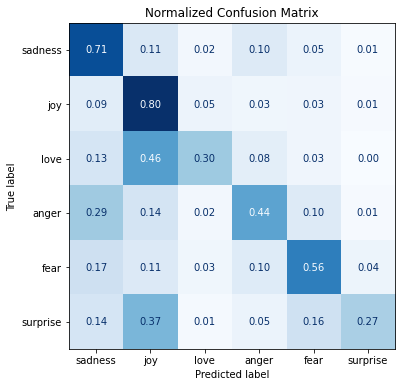

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize = "true")
  fig, ax = plt.subplots(figsize = (6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  disp.plot(cmap = "Blues", values_format = ".2f", ax = ax, colorbar = False)
  plt.title("Normalized Confusion Matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Here are some observations from the confusion matrix -

1. We can see "anger" and "fear" are most often confused with "sadness".
2. Also "love" and "surprise" are frequently mistaken for "joy".



### Fine-Tuning Transformers

With fine-tuning approach we do not use the hidden states as fixed features, but instead train them which requires the classifcation head to be differentiable.

In [69]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device))

Defining the performance metrics

In [70]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [71]:
from transformers import Trainer, TrainingArguments

In [72]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  log_level = "error")

In [73]:
from transformers import Trainer

trainer = Trainer(model = model, args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded["train"],
                  eval_dataset = emotions_encoded["validation"],
                  tokenizer = tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833800,0.325671,0.900500,0.896533
2,0.256100,0.221838,0.925500,0.925528


TrainOutput(global_step=500, training_loss=0.5449150085449219, metrics={'train_runtime': 249.2867, 'train_samples_per_second': 128.366, 'train_steps_per_second': 2.006, 'total_flos': 720342861696000.0, 'train_loss': 0.5449150085449219, 'epoch': 2.0})

This is lot better compared to the logistic regression which was trained on the hidden state. Fine-tuning the weights and the entire network yield much better result.

In [74]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [75]:
preds_output.metrics

{'test_loss': 0.22183772921562195,
 'test_accuracy': 0.9255,
 'test_f1': 0.9255278407911122,
 'test_runtime': 4.8406,
 'test_samples_per_second': 413.175,
 'test_steps_per_second': 6.611}

In [76]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

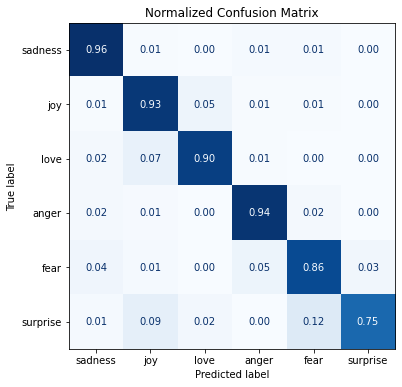

In [77]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix. "Love" category is still getting confused with "Joy" which also seems natural. "Surprise" is also at times mistaken for "joy" or "fear".

The overall performance of the model seems quite good.

### Error Analysis

A very powerful technique is to sort the validation samples by the model loss.
Here we will pass the label during the forward pass, the loss is automatically calculated and returned.

In [78]:
from torch.nn.functional import cross_entropy 

def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis = -1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction = "none")

  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [79]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

In [80]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched = True, batch_size = 16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [81]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [82]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.022819
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.020533
2,i feel like a faithful servant,love,love,0.490512
3,i am just feeling cranky and blue,anger,anger,0.039255
4,i can have for a treat or if i am feeling festive,joy,joy,0.022171


The goal of sorting the examples by losses is to detect the following -

1. Wrong Labels : There could be wrongly labeled annotated data either by human or by automation. With this process we can quickly correct them

2. Quirks of the dataset : Inspecting the model's weakest predictions can help identify some patterns or features which are casuing an issue. Cleaning the data or injecting similar examples can make the model more robust.

In [83]:
df_test.sort_values("loss", ascending = False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.612621
765,i feel super awkward and out of place right now,joy,sadness,5.496145
465,i would eventually go in to these stores but i...,joy,fear,5.493650
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.341931
1509,i guess this is a memoir so it feels like that...,joy,fear,5.314481
882,i feel badly about reneging on my commitment t...,love,sadness,5.302475
1963,i called myself pro life and voted for perry w...,joy,sadness,5.174412
1801,i feel that he was being overshadowed by the s...,love,sadness,5.123425
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.118912
1950,i as representative of everything thats wrong ...,surprise,sadness,5.088850


In [84]:
df_test.sort_values("loss", ascending = True).head(10)

,text,label,predicted_label,loss
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.016652
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.016659
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.016723
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016768
650,i am still feeling gloomy and down,sadness,sadness,0.016830
1665,i feel a lil bit gloomy,sadness,sadness,0.016857
1188,ive been feeling really gloomy about some situ...,sadness,sadness,0.016895
323,im starting to feel unwelcome in there,sadness,sadness,0.016907
1041,i suppose it all goes along with feeling unwel...,sadness,sadness,0.016950
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.016975


We can see here that "joy" is sometimes mislabeled and that the model is most confident about predicting the label "sadness". With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

### Inference Pipeline

In [85]:
model_name

'distilbert-base-uncased-finetuned-emotion'

In [89]:
model_id = model_name + '/checkpoint-500'
model_id

'distilbert-base-uncased-finetuned-emotion/checkpoint-500'

In [86]:
from transformers import pipeline

In [90]:
classifier = pipeline("text-classification", model = model_id)

In [91]:
custom_tweet = "I watched a nice movie today and have a fabulous time."
preds = classifier(custom_tweet, return_all_scores = True)

In [94]:
preds_df = pd.DataFrame(preds[0])
preds_df

,label,score
0,LABEL_0,0.004443
1,LABEL_1,0.972880
2,LABEL_2,0.009200
3,LABEL_3,0.004394
4,LABEL_4,0.002925
5,LABEL_5,0.006159


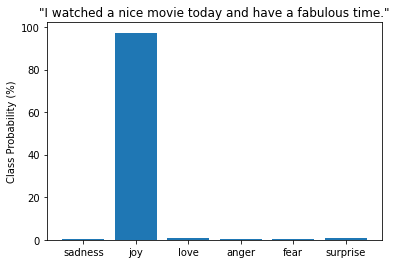

In [95]:
plt.bar(labels, 100 * preds_df["score"], color = 'C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class Probability (%)")
plt.show()